Test the dataset maker

In [1]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src import utils
import src.data
import src.data.build
import opensoundscape as opso

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# load the data
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "processed" / "train_set"
df_train = pd.read_pickle(train_df_path / "train_set.pkl")

downloading 0 clips
skipped 0 previously downloaded files


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/data/build.py:163: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.drop(df.loc[df.target_presence == False][df.target_absence == False].index)


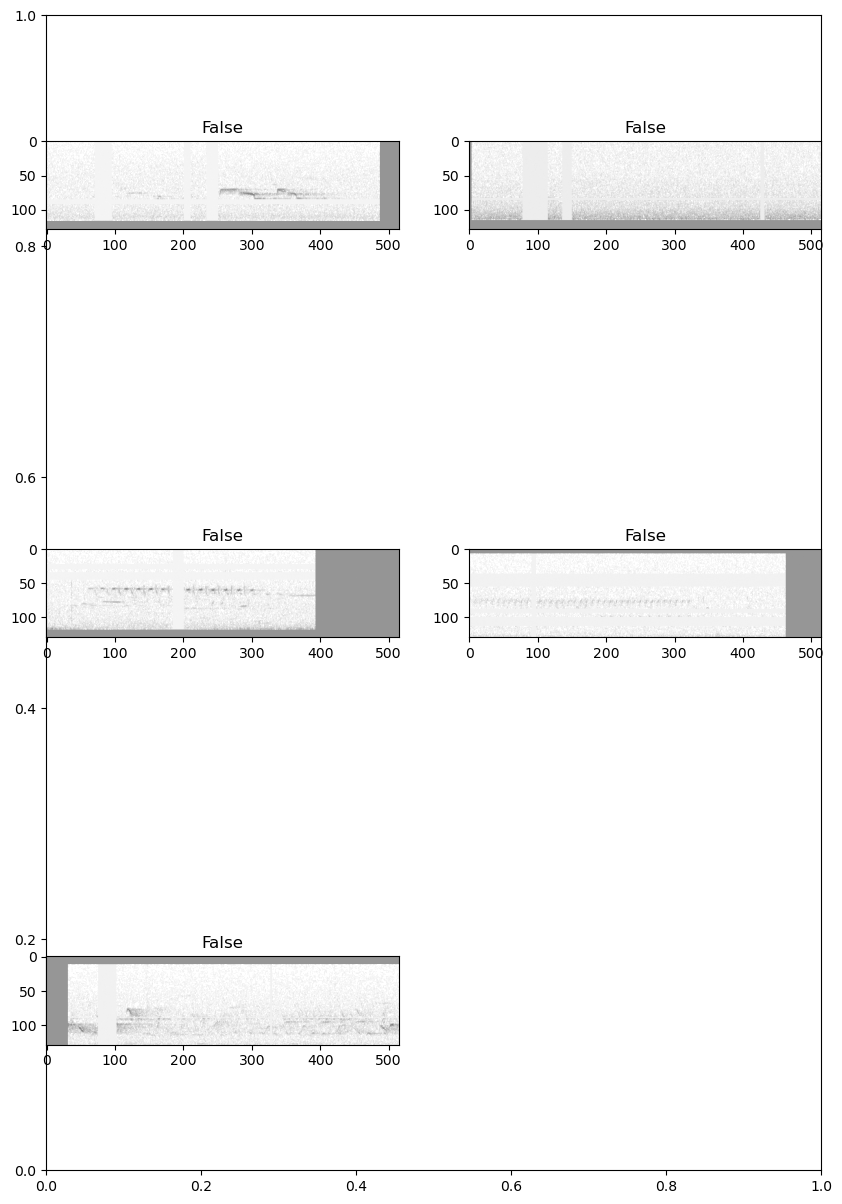

In [3]:
training_dataset = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0)

In [4]:
training_dataset.__class__

opensoundscape.ml.datasets.AudioFileDataset

Can these datasets be interfaced with the fastai dataloaders and training schedules?

In [5]:
from fastai.vision.core import DataLoaders
from torch.utils.data._utils.collate import default_collate

In [6]:
osfl_dls = DataLoaders.from_dsets(training_dataset,training_dataset)

Calling 
``` python 
osfl_dls[0].one_batch()
```
 raises an error since the top level of the DataLoader contains an AudioSample object rather than a tensor

The \__getitem__ method contained in the AudioDataSet doesn't directly return the tensors. Fastai expects the DataSet to be an iterable of tensors, so we'll make a custom collate function to provide these:

In [7]:
type(training_dataset[0].data)

torch.Tensor

In [8]:
def custom_collate(batch):
    # Extract the .data from each AudioSample in the batch
    tensor_batch = [(item.data, item.labels.iloc[0]) for item in batch]
    # Use the default collate function to combine these into a batch
    return default_collate(tensor_batch)


In [9]:
osfl_dls = DataLoaders.from_dsets(training_dataset, bs=64, before_batch=custom_collate)

In [14]:
# osfl_dls.one_batch()

RuntimeError: stack expects each tensor to be equal size, but got [1, 129, 515] at entry 0 and [1, 236, 280] at entry 12

### Problem: the tensors from different recordings are being converted to tensors of different sizes. 

Look into why this is - the spectrograms need to all be the same dimensions. 